In [101]:
# Install Dependencies
import pandas as pd
from matplotlib import pyplot
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from numpy import concatenate
from math import sqrt

In [68]:
# import NYT dataset
df=pd.read_csv("Potential Data Sources/NYT- Cty Cases Deaths Thru Oct2/us-counties.csv", parse_dates=['date'])
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [69]:
# limit dataset to texas
Texas=df.loc[df['state']=='Texas']

In [70]:
# limit dataset to certain County
Texas_County=Texas.loc[df['county']=='Dallas']
Texas_County

,date,county,state,fips,cases,deaths
1133,2020-03-10,Dallas,Texas,48113.0,2,0
1329,2020-03-11,Dallas,Texas,48113.0,3,0
1576,2020-03-12,Dallas,Texas,48113.0,8,0
1881,2020-03-13,Dallas,Texas,48113.0,9,0
2247,2020-03-14,Dallas,Texas,48113.0,11,0
...,...,...,...,...,...,...
582494,2020-09-29,Dallas,Texas,48113.0,86213,1126
585734,2020-09-30,Dallas,Texas,48113.0,86500,1133
588975,2020-10-01,Dallas,Texas,48113.0,86500,1137
592215,2020-10-02,Dallas,Texas,48113.0,86500,1139


In [71]:
County_Cases=Texas_County.drop(['state', 'deaths', 'county', 'fips'], axis=1)
County_Cases=County_Cases.set_index('date')
County_Cases=County_Cases.fillna(0)
County_Cases

,cases
date,
2020-03-10,2
2020-03-11,3
2020-03-12,8
2020-03-13,9
2020-03-14,11
...,...
2020-09-29,86213
2020-09-30,86500
2020-10-01,86500


In [72]:
fig = px.line(County_Cases)
fig.show()

In [73]:
# As evident from the chart the data is trending upward with time in a recursive manner 
# (meaning today's value is dependent on yesterday's value).  It does not satisfy the stationary requirement for
# ML timeseries models. So we need to transform it.  The first way we do this is by taking the difference of the current 
# datapoint from yesterdays datapoint and then changin na values to 0:
County_Cases_Differenced=County_Cases.diff().fillna(0)
County_Cases_Differenced

,cases
date,
2020-03-10,0.0
2020-03-11,1.0
2020-03-12,5.0
2020-03-13,1.0
2020-03-14,2.0
...,...
2020-09-29,803.0
2020-09-30,287.0
2020-10-01,0.0


In [74]:
# then we check the plot again:
fig2 = px.line(County_Cases_Differenced)
fig2.show()

#  Mobility Data

In [75]:
# import mobility dataset
raw_mobility=pd.read_csv("Potential Data Sources/Google US Mobility/2020_US_Region_Mobility_Report.csv", parse_dates=['date'])
raw_mobility.tail()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
581567,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-09-28,NaN,NaN,NaN,NaN,-22.0,NaN
581568,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-09-29,NaN,NaN,NaN,NaN,-15.0,NaN
581569,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-09-30,NaN,NaN,NaN,NaN,-19.0,NaN
581570,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-10-01,NaN,NaN,NaN,NaN,-14.0,NaN
581571,US,United States,Wyoming,Weston County,NaN,NaN,56045.0,2020-10-02,NaN,NaN,NaN,NaN,-12.0,NaN


In [76]:
# drop unnecessary columns and rename columns to standardize with NYT data
dropped_mobility=raw_mobility.drop(['country_region_code','country_region','metro_area','iso_3166_2_code'], axis=1)
dropped_mobility.rename(columns={'sub_region_1':'state','sub_region_2':'county','census_fips_code':'fips',
                                 'retail_and_recreation_percent_change_from_baseline':'% change retail and recreation',
                                 'grocery_and_pharmacy_percent_change_from_baseline':'% change grocery and pharmacy',
                                 'parks_percent_change_from_baseline':'% change parks',
                                 'transit_stations_percent_change_from_baseline':'% change transit stations',
                                 'workplaces_percent_change_from_baseline':'% change workplaces',
                                 'residential_percent_change_from_baseline':'% change residential'}, inplace=True)
dropped_mobility.tail()

,state,county,fips,date,% change retail and recreation,% change grocery and pharmacy,% change parks,% change transit stations,% change workplaces,% change residential
581567,Wyoming,Weston County,56045.0,2020-09-28,NaN,NaN,NaN,NaN,-22.0,NaN
581568,Wyoming,Weston County,56045.0,2020-09-29,NaN,NaN,NaN,NaN,-15.0,NaN
581569,Wyoming,Weston County,56045.0,2020-09-30,NaN,NaN,NaN,NaN,-19.0,NaN
581570,Wyoming,Weston County,56045.0,2020-10-01,NaN,NaN,NaN,NaN,-14.0,NaN
581571,Wyoming,Weston County,56045.0,2020-10-02,NaN,NaN,NaN,NaN,-12.0,NaN


In [77]:
# filter to texas & Dallas County
texas_mobility=dropped_mobility.loc[dropped_mobility['state']=='Texas']
texas_mobility=texas_mobility.drop(['state'], axis=1)
county_mobility=texas_mobility.loc[dropped_mobility['county']=='Dallas County']
county_mobility

,county,fips,date,% change retail and recreation,% change grocery and pharmacy,% change parks,% change transit stations,% change workplaces,% change residential
476181,Dallas County,48113.0,2020-02-15,4.0,1.0,16.0,0.0,1.0,-1.0
476182,Dallas County,48113.0,2020-02-16,9.0,2.0,50.0,3.0,1.0,-2.0
476183,Dallas County,48113.0,2020-02-17,7.0,0.0,39.0,-2.0,-18.0,4.0
476184,Dallas County,48113.0,2020-02-18,-4.0,-4.0,-7.0,-2.0,3.0,1.0
476185,Dallas County,48113.0,2020-02-19,-2.0,-2.0,-8.0,-3.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...
476409,Dallas County,48113.0,2020-09-30,-16.0,-6.0,18.0,-31.0,-36.0,9.0
476410,Dallas County,48113.0,2020-10-01,-15.0,-6.0,16.0,-32.0,-35.0,9.0
476411,Dallas County,48113.0,2020-10-02,-15.0,-10.0,4.0,-25.0,-33.0,7.0
476412,Dallas County,48113.0,2020-10-03,-17.0,-7.0,16.0,-19.0,-16.0,3.0


In [78]:
county_mobility=county_mobility.dropna()
county_mobility=county_mobility.drop(['county','fips'], axis=1)
county_mobility=county_mobility.set_index('date')
county_mobility=county_mobility.apply(pd.to_numeric)
county_mobility.head()

,% change retail and recreation,% change grocery and pharmacy,% change parks,% change transit stations,% change workplaces,% change residential
date,,,,,,
2020-02-15,4.0,1.0,16.0,0.0,1.0,-1.0
2020-02-16,9.0,2.0,50.0,3.0,1.0,-2.0
2020-02-17,7.0,0.0,39.0,-2.0,-18.0,4.0
2020-02-18,-4.0,-4.0,-7.0,-2.0,3.0,1.0
2020-02-19,-2.0,-2.0,-8.0,-3.0,5.0,0.0


In [79]:
merge=pd.merge(County_Cases_Differenced,county_mobility, how='inner', left_index=True, right_index=True)
merge

,cases,% change retail and recreation,% change grocery and pharmacy,% change parks,% change transit stations,% change workplaces,% change residential
date,,,,,,,
2020-03-10,0.0,11.0,6.0,71.0,1.0,-4.0,0.0
2020-03-11,1.0,14.0,15.0,69.0,3.0,-3.0,-1.0
2020-03-12,5.0,10.0,25.0,40.0,-2.0,-7.0,0.0
2020-03-13,1.0,0.0,32.0,-28.0,-14.0,-12.0,4.0
2020-03-14,2.0,-12.0,14.0,-37.0,-15.0,-6.0,5.0
...,...,...,...,...,...,...,...
2020-09-29,803.0,-18.0,-12.0,13.0,-34.0,-36.0,10.0
2020-09-30,287.0,-16.0,-6.0,18.0,-31.0,-36.0,9.0
2020-10-01,0.0,-15.0,-6.0,16.0,-32.0,-35.0,9.0


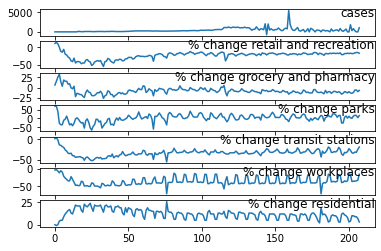

In [80]:
values = merge.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(merge.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# LSTM Data Preparation

In [81]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [82]:
# ensure all data is float
values = values.astype('float32')

In [83]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [84]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [85]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
# print(reframed.head())
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.116804,0.956522,0.551724,1.000000,0.965517,0.985507,0.037037,0.116969
2,0.116969,1.000000,0.706897,0.985612,1.000000,1.000000,0.000000,0.117628
3,0.117628,0.942029,0.879310,0.776978,0.913793,0.942029,0.037037,0.116969
4,0.116969,0.797101,1.000000,0.287770,0.706897,0.869565,0.185185,0.117133
5,0.117133,0.623188,0.689655,0.223022,0.689655,0.956522,0.222222,0.117298
...,...,...,...,...,...,...,...,...
203,0.168040,0.536232,0.206897,0.489209,0.379310,0.507246,0.407407,0.249094
204,0.249094,0.536232,0.241379,0.582734,0.362069,0.521739,0.407407,0.164086
205,0.164086,0.565217,0.344828,0.618705,0.413793,0.521739,0.370370,0.116804
206,0.116804,0.579710,0.344828,0.604317,0.396552,0.536232,0.370370,0.116804


# Define and Fit Model

In [86]:
# split into train and test sets
values = reframed.values
n_train_days = int(.8*len(reframed))
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [87]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [88]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(165, 1, 7) (165,) (42, 1, 7) (42,)


In [89]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [90]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
3/3 - 1s - loss: 0.1499 - val_loss: 0.1094
Epoch 2/50
3/3 - 0s - loss: 0.1200 - val_loss: 0.0784
Epoch 3/50
3/3 - 0s - loss: 0.0922 - val_loss: 0.0569
Epoch 4/50
3/3 - 0s - loss: 0.0664 - val_loss: 0.0438
Epoch 5/50
3/3 - 0s - loss: 0.0513 - val_loss: 0.0458
Epoch 6/50
3/3 - 0s - loss: 0.0532 - val_loss: 0.0538
Epoch 7/50
3/3 - 0s - loss: 0.0598 - val_loss: 0.0590
Epoch 8/50
3/3 - 0s - loss: 0.0643 - val_loss: 0.0604
Epoch 9/50
3/3 - 0s - loss: 0.0652 - val_loss: 0.0587
Epoch 10/50
3/3 - 0s - loss: 0.0632 - val_loss: 0.0552
Epoch 11/50
3/3 - 0s - loss: 0.0598 - val_loss: 0.0511
Epoch 12/50
3/3 - 0s - loss: 0.0564 - val_loss: 0.0474
Epoch 13/50
3/3 - 0s - loss: 0.0537 - val_loss: 0.0451
Epoch 14/50
3/3 - 0s - loss: 0.0519 - val_loss: 0.0444
Epoch 15/50
3/3 - 0s - loss: 0.0508 - val_loss: 0.0441
Epoch 16/50
3/3 - 0s - loss: 0.0503 - val_loss: 0.0441
Epoch 17/50
3/3 - 0s - loss: 0.0499 - val_loss: 0.0443
Epoch 18/50
3/3 - 0s - loss: 0.0496 - val_loss: 0.0447
Epoch 19/50
3/3 - 0

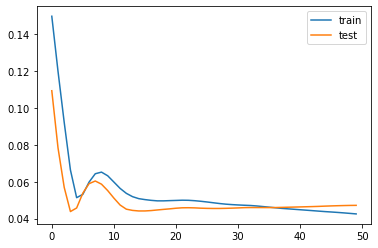

In [91]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate Model

In [92]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [96]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [97]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [102]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 366.554
